In [26]:
#import autograd.numpy as np

class Scheduler:
    """
    Abstract class for Schedulers
    """

    def __init__(self, eta):
        self.eta = eta

    # should be overwritten
    def update_change(self, gradient):
        raise NotImplementedError

    # overwritten if needed
    def reset(self):
        pass


class Constant(Scheduler):
    def __init__(self, eta):
        super().__init__(eta)

    def update_change(self, gradient):
        return self.eta * gradient
    
    def reset(self):
        pass


class Momentum(Scheduler):
    def __init__(self, eta: float, momentum: float):
        super().__init__(eta)
        self.momentum = momentum
        self.change = 0

    def update_change(self, gradient):
        self.change = self.momentum * self.change + self.eta * gradient
        return self.change

    def reset(self):
        pass


class Adagrad(Scheduler):
    def __init__(self, eta):
        super().__init__(eta)
        self.G_t = None

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero

        if self.G_t is None:
            self.G_t = npf.zeros((gradient.shape[0], gradient.shape[0]))

        self.G_t += gradient @ gradient.T

        G_t_inverse = 1 / (
            delta + npf.sqrt(npf.reshape(npf.diagonal(self.G_t), (self.G_t.shape[0], 1)))
        )
        return self.eta * gradient * G_t_inverse

    def reset(self):
        self.G_t = None


class AdagradMomentum(Scheduler):
    def __init__(self, eta, momentum):
        super().__init__(eta)
        self.G_t = None
        self.momentum = momentum
        self.change = 0

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero

        if self.G_t is None:
            self.G_t = npf.zeros((gradient.shape[0], gradient.shape[0]))

        self.G_t += gradient @ gradient.T

        G_t_inverse = 1 / (
            delta + npf.sqrt(npf.reshape(npf.diagonal(self.G_t), (self.G_t.shape[0], 1)))
        )
        self.change = self.change * self.momentum + self.eta * gradient * G_t_inverse
        return self.change

    def reset(self):
        self.G_t = None


class RMS_prop(Scheduler):
    def __init__(self, eta, rho):
        super().__init__(eta)
        self.rho = rho
        self.second = 0.0

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero
        self.second = self.rho * self.second + (1 - self.rho) * gradient * gradient
        return self.eta * gradient / (npf.sqrt(self.second + delta))

    def reset(self):
        self.second = 0.0


class Adam(Scheduler):
    def __init__(self, eta, rho, rho2):
        super().__init__(eta)
        self.rho = rho
        self.rho2 = rho2
        self.moment = 0
        self.second = 0
        self.n_epochs = 1

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero

        self.moment = self.rho * self.moment + (1 - self.rho) * gradient
        self.second = self.rho2 * self.second + (1 - self.rho2) * gradient * gradient

        moment_corrected = self.moment / (1 - self.rho**self.n_epochs)
        second_corrected = self.second / (1 - self.rho2**self.n_epochs)

        return self.eta * moment_corrected / (npf.sqrt(second_corrected + delta))

    def reset(self):
        self.n_epochs += 1
        self.moment = 0
        self.second = 0

In [27]:
#import autograd.numpy as np

def CostOLS(target):
    
    def func(X):
        return (1.0 / target.shape[0]) * npf.sum((target - X) ** 2)

    return func


def CostLogReg(target):

    def func(X):
        epsilon = 1e-10
        # Apply epsilon to prevent log(0) or log(1) which results in numerical instability
        X = npf.clip(X, epsilon, 1 - epsilon)
        return -(1.0 / target.shape[0]) * npf.sum(
            (target * npf.log(X)) + ((1 - target) * npf.log(1 - X))
            )      

    return func


def CostCrossEntropy(target):
    
    def func(X):
        return -(1.0 / target.size) * npf.sum(target * npf.log(X + 10e-10))

    return func

In [28]:
#import autograd.numpy as np
#from autograd import elementwise_grad

def identity(X):
    return X


def sigmoid(X):
    try:
        return 1.0 / (1 + npf.exp(-X))
    except FloatingPointError:
        return npf.where(X > npf.zeros(X.shape), npf.ones(X.shape), npf.zeros(X.shape))


def softmax(X):
    X = X - npf.max(X, axis=-1, keepdims=True)
    delta = 10e-10
    return npf.exp(X) / (npf.sum(npf.exp(X), axis=-1, keepdims=True) + delta)


def RELU(X):
    return npf.where(X > npf.zeros(X.shape), X, npf.zeros(X.shape))


def LRELU(X):
    delta = 10e-4
    return npf.where(X > npf.zeros(X.shape), X, delta * X)


def derivate(func):
    if func.__name__ == "RELU":

        def func(X):
            return npf.where(X > 0, 1, 0)

        return func

    elif func.__name__ == "LRELU":

        def func(X):
            delta = 10e-4
            return npf.where(X > 0, 1, delta)

        return func

    else:
        return elementwise_grad(func)

In [29]:
import math
import autograd.numpy as npf
import sys
import warnings
from autograd import grad, elementwise_grad
from random import random, seed
from copy import deepcopy, copy
from typing import Tuple, Callable
from sklearn.utils import resample

warnings.simplefilter("error")


class FFNN:
    """
    Description:
    ------------
    https://github.com/CompPhysics/MachineLearning/blob/master/doc/LectureNotes/week43.ipynb
        
        Feed Forward Neural Network with interface enabling flexible design of a
        nerual networks architecture and the specification of activation function
        in the hidden layers and output layer respectively. This model can be used
        for both regression and classification problems, depending on the output function.

    Attributes:
    ------------
        I   dimensions (tuple[int]): A list of positive integers, which specifies the
            number of nodes in each of the networks layers. The first integer in the array
            defines the number of nodes in the input layer, the second integer defines number
            of nodes in the first hidden layer and so on until the last number, which
            specifies the number of nodes in the output layer.
        II  hidden_func (Callable): The activation function for the hidden layers
        III output_func (Callable): The activation function for the output layer
        IV  cost_func (Callable): Our cost function
        V   seed (int): Sets random seed, makes results reproducible
    """

    def __init__(
        self,
        dimensions: tuple[int],
        hidden_func: Callable = sigmoid,
        output_func: Callable = lambda x: x,
        cost_func: Callable = CostOLS,
        seed: int = None,
    ):
        self.dimensions = dimensions
        self.hidden_func = hidden_func
        self.output_func = output_func
        self.cost_func = cost_func
        self.seed = seed
        self.weights = list()
        self.schedulers_weight = list()
        self.schedulers_bias = list()
        self.a_matrices = list()
        self.z_matrices = list()
        self.classification = None

        self.reset_weights()
        self._set_classification()

    def fit(
        self,
        X: npf.ndarray,
        t: npf.ndarray,
        scheduler: Scheduler,
        batches: int = 1,
        epochs: int = 100,
        lam: float = 0,
        X_val: npf.ndarray = None,
        t_val: npf.ndarray = None,
    ):
        """
        Description:
        ------------
            This function performs the training the neural network by performing the feedforward and backpropagation
            algorithm to update the networks weights.

        Parameters:
        ------------
            I    X (np.ndarray) : training data
            II   t (np.ndarray) : target data
            III  scheduler (Scheduler) : specified scheduler (algorithm for optimization of gradient descent)
            IV   scheduler_args (list[int]) : list of all arguments necessary for scheduler

        Optional Parameters:
        ------------
            V    batches (int) : number of batches the datasets are split into, default equal to 1
            VI   epochs (int) : number of iterations used to train the network, default equal to 100
            VII  lam (float) : regularization hyperparameter lambda
            VIII X_val (np.ndarray) : validation set
            IX   t_val (np.ndarray) : validation target set

        Returns:
        ------------
            I   scores (dict) : A dictionary containing the performance metrics of the model.
                The number of the metrics depends on the parameters passed to the fit-function.

        """

        # setup 
        if self.seed is not None:
            npf.random.seed(self.seed)

        val_set = False
        if X_val is not None and t_val is not None:
            val_set = True

        # creating arrays for score metrics
        train_errors = npf.empty(epochs)
        train_errors.fill(npf.nan)
        val_errors = npf.empty(epochs)
        val_errors.fill(npf.nan)

        train_accs = npf.empty(epochs)
        train_accs.fill(npf.nan)
        val_accs = npf.empty(epochs)
        val_accs.fill(npf.nan)

        self.schedulers_weight = list()
        self.schedulers_bias = list()

        batch_size = X.shape[0] // batches

        X, t = resample(X, t)

        # this function returns a function valued only at X
        cost_function_train = self.cost_func(t)
        if val_set:
            cost_function_val = self.cost_func(t_val)

        # create schedulers for each weight matrix
        for i in range(len(self.weights)):
            self.schedulers_weight.append(copy(scheduler))
            self.schedulers_bias.append(copy(scheduler))

        print(f"{scheduler.__class__.__name__}: Eta={scheduler.eta}, Lambda={lam}")

        try:
            for e in range(epochs):
                for i in range(batches):
                    # allows for minibatch gradient descent
                    if i == batches - 1:
                        # If the for loop has reached the last batch, take all thats left
                        X_batch = X[i * batch_size :, :]
                        t_batch = t[i * batch_size :, :]
                    else:
                        X_batch = X[i * batch_size : (i + 1) * batch_size, :]
                        t_batch = t[i * batch_size : (i + 1) * batch_size, :]

                    self._feedforward(X_batch)
                    self._backpropagate(X_batch, t_batch, lam)

                # reset schedulers for each epoch (some schedulers pass in this call)
                for scheduler in self.schedulers_weight:
                    scheduler.reset()

                for scheduler in self.schedulers_bias:
                    scheduler.reset()

                # computing performance metrics
                pred_train = self.predict(X)
                train_error = cost_function_train(pred_train)

                train_errors[e] = train_error
                if val_set:
                    
                    pred_val = self.predict(X_val)
                    val_error = cost_function_val(pred_val)
                    val_errors[e] = val_error

                if self.classification:
                    train_acc = self._accuracy(self.predict(X), t)
                    train_accs[e] = train_acc
                    if val_set:
                        val_acc = self._accuracy(pred_val, t_val)
                        val_accs[e] = val_acc

                # printing progress bar
                progression = e / epochs
                print_length = self._progress_bar(
                    progression,
                    train_error=train_errors[e],
                    train_acc=train_accs[e],
                    val_error=val_errors[e],
                    val_acc=val_accs[e],
                )
        except KeyboardInterrupt:
            # allows for stopping training at any point and seeing the result
            pass

        # visualization of training progression (similiar to tensorflow progression bar)
        sys.stdout.write("\r" + " " * print_length)
        sys.stdout.flush()
        self._progress_bar(
            1,
            train_error=train_errors[e],
            train_acc=train_accs[e],
            val_error=val_errors[e],
            val_acc=val_accs[e],
        )
        sys.stdout.write("")

        # return performance metrics for the entire run
        scores = dict()

        scores["train_errors"] = train_errors

        if val_set:
            scores["val_errors"] = val_errors

        if self.classification:
            scores["train_accs"] = train_accs

            if val_set:
                scores["val_accs"] = val_accs

        return scores

    def predict(self, X: npf.ndarray, *, threshold=0.5):
        """
         Description:
         ------------
             Performs prediction after training of the network has been finished.

         Parameters:
        ------------
             I   X (np.ndarray): The design matrix, with n rows of p features each

         Optional Parameters:
         ------------
             II  threshold (float) : sets minimal value for a prediction to be predicted as the positive class
                 in classification problems

         Returns:
         ------------
             I   z (np.ndarray): A prediction vector (row) for each row in our design matrix
                 This vector is thresholded if regression=False, meaning that classification results
                 in a vector of 1s and 0s, while regressions in an array of decimal numbers

        """

        predict = self._feedforward(X)

        if self.classification:
            return npf.where(predict > threshold, 1, 0)
        else:
            return predict

    def reset_weights(self):
        """
        Description:
        ------------
            Resets/Reinitializes the weights in order to train the network for a new problem.

        """
        if self.seed is not None:
            npf.random.seed(self.seed)

        self.weights = list()
        for i in range(len(self.dimensions) - 1):
            weight_array = npf.random.randn(
                self.dimensions[i] + 1, self.dimensions[i + 1]
            )
            weight_array[0, :] = npf.random.randn(self.dimensions[i + 1]) * 0.01

            self.weights.append(weight_array)

    def _feedforward(self, X: npf.ndarray):
        """
        Description:
        ------------
            Calculates the activation of each layer starting at the input and ending at the output.
            Each following activation is calculated from a weighted sum of each of the preceeding
            activations (except in the case of the input layer).

        Parameters:
        ------------
            I   X (np.ndarray): The design matrix, with n rows of p features each

        Returns:
        ------------
            I   z (np.ndarray): A prediction vector (row) for each row in our design matrix
        """

        # reset matrices
        self.a_matrices = list()
        self.z_matrices = list()

        # if X is just a vector, make it into a matrix
        if len(X.shape) == 1:
            X = X.reshape((1, X.shape[0]))

        # Add a coloumn of zeros as the first coloumn of the design matrix, in order
        # to add bias to our data
        bias = npf.ones((X.shape[0], 1)) * 0.01
        X = npf.hstack([bias, X])

        # a^0, the nodes in the input layer (one a^0 for each row in X - where the
        # exponent indicates layer number).
        a = X
        self.a_matrices.append(a)
        self.z_matrices.append(a)

        # The feed forward algorithm
        for i in range(len(self.weights)):
            if i < len(self.weights) - 1:
                z = a @ self.weights[i]
                self.z_matrices.append(z)
                a = self.hidden_func(z)
                # bias column again added to the data here
                bias = npf.ones((a.shape[0], 1)) * 0.01
                a = npf.hstack([bias, a])
                self.a_matrices.append(a)
            else:
                try:
                    # a^L, the nodes in our output layers
                    z = a @ self.weights[i]
                    a = self.output_func(z)
                    self.a_matrices.append(a)
                    self.z_matrices.append(z)
                except Exception as OverflowError:
                    print(
                        "OverflowError in fit() in FFNN\nHOW TO DEBUG ERROR: Consider lowering your learning rate or scheduler specific parameters such as momentum, or check if your input values need scaling"
                    )

        # this will be a^L
        return a

    def _backpropagate(self, X, t, lam):
        """
        Description:
        ------------
            Performs the backpropagation algorithm. In other words, this method
            calculates the gradient of all the layers starting at the
            output layer, and moving from right to left accumulates the gradient until
            the input layer is reached. Each layers respective weights are updated while
            the algorithm propagates backwards from the output layer (auto-differentation in reverse mode).

        Parameters:
        ------------
            I   X (np.ndarray): The design matrix, with n rows of p features each.
            II  t (np.ndarray): The target vector, with n rows of p targets.
            III lam (float32): regularization parameter used to punish the weights in case of overfitting

        Returns:
        ------------
            No return value.

        """
        out_derivative = derivate(self.output_func)
        hidden_derivative = derivate(self.hidden_func)

        for i in range(len(self.weights) - 1, -1, -1):
            # delta terms for output
            if i == len(self.weights) - 1:
                # for multi-class classification
                if (
                    self.output_func.__name__ == "softmax"
                ):
                    delta_matrix = self.a_matrices[i + 1] - t
                # for single class classification
                else:
                    cost_func_derivative = grad(self.cost_func(t))
                    delta_matrix = out_derivative(
                        self.z_matrices[i + 1]
                    ) * cost_func_derivative(self.a_matrices[i + 1])

            # delta terms for hidden layer
            else:
                delta_matrix = (
                    self.weights[i + 1][1:, :] @ delta_matrix.T
                ).T * hidden_derivative(self.z_matrices[i + 1])

            # calculate gradient
            gradient_weights = self.a_matrices[i][:, 1:].T @ delta_matrix
            gradient_bias = npf.sum(delta_matrix, axis=0).reshape(
                1, delta_matrix.shape[1]
            )

            # regularization term
            gradient_weights += self.weights[i][1:, :] * lam

            # use scheduler
            update_matrix = npf.vstack(
                [
                    self.schedulers_bias[i].update_change(gradient_bias),
                    self.schedulers_weight[i].update_change(gradient_weights),
                ]
            )

            # update weights and bias
            self.weights[i] -= update_matrix

    def _accuracy(self, prediction: npf.ndarray, target: npf.ndarray):
        """
        Description:
        ------------
            Calculates accuracy of given prediction to target

        Parameters:
        ------------
            I   prediction (np.ndarray): vector of predicitons output network
                (1s and 0s in case of classification, and real numbers in case of regression)
            II  target (np.ndarray): vector of true values (What the network ideally should predict)

        Returns:
        ------------
            A floating point number representing the percentage of correctly classified instances.
        """
        assert prediction.size == target.size
        return npf.average((target == prediction))
    def _set_classification(self):
        """
        Description:
        ------------
            Decides if FFNN acts as classifier (True) og regressor (False),
            sets self.classification during init()
        """
        self.classification = False
        if (
            self.cost_func.__name__ == "CostLogReg"
            or self.cost_func.__name__ == "CostCrossEntropy"
        ):
            self.classification = True

    def _progress_bar(self, progression, **kwargs):
        """
        Description:
        ------------
            Displays progress of training
        """
        print_length = 40
        num_equals = int(progression * print_length)
        num_not = print_length - num_equals
        arrow = ">" if num_equals > 0 else ""
        bar = "[" + "=" * (num_equals - 1) + arrow + "-" * num_not + "]"
        perc_print = self._format(progression * 100, decimals=5)
        line = f"  {bar} {perc_print}% "

        for key in kwargs:
            if not npf.isnan(kwargs[key]):
                value = self._format(kwargs[key], decimals=4)
                line += f"| {key}: {value} "
        sys.stdout.write("\r" + line)
        sys.stdout.flush()
        return len(line)

    def _format(self, value, decimals=4):
        """
        Description:
        ------------
            Formats decimal numbers for progress bar
        """
        if value > 0:
            v = value
        elif value < 0:
            v = -10 * value
        else:
            v = 1
        n = 1 + math.floor(math.log10(v))
        if n >= decimals - 1:
            return str(round(value))
        return f"{value:.{decimals-n-1}f}"

Adam: Eta=0.0001, Lambda=0.001
  [=======================================>] 100.0% | train_error: 0.108 | train_acc: 0.995  

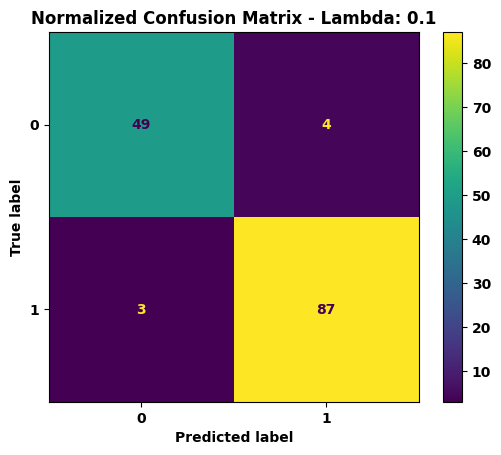

Adam: Eta=0.0001, Lambda=0.005
  [=======================================>] 100.0% | train_error: 0.541 | train_acc: 0.977  

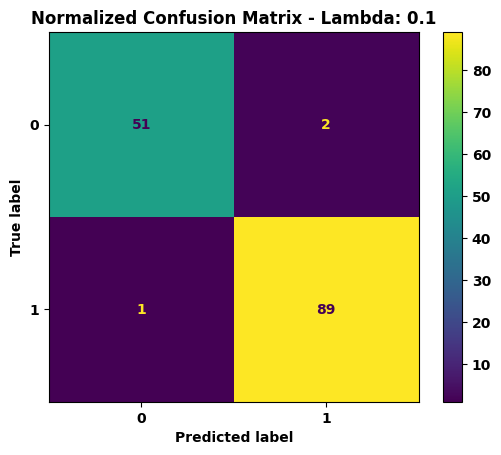

Adam: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.378 | train_acc: 0.984  

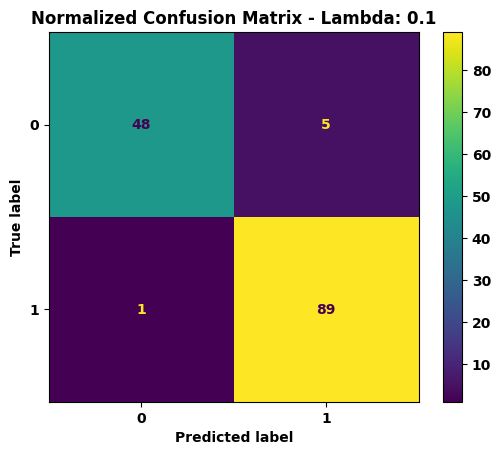

Adam: Eta=0.0001, Lambda=0.05
  [=======================================>] 100.0% | train_error: 1.57 | train_acc: 0.932   

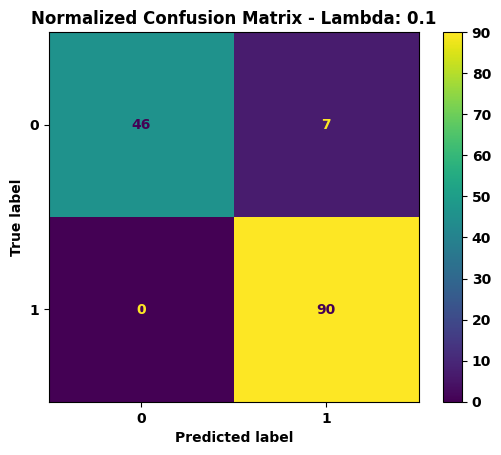

Adam: Eta=0.0001, Lambda=0.1
  [=======================================>] 100.0% | train_error: 8.97 | train_acc: 0.610   

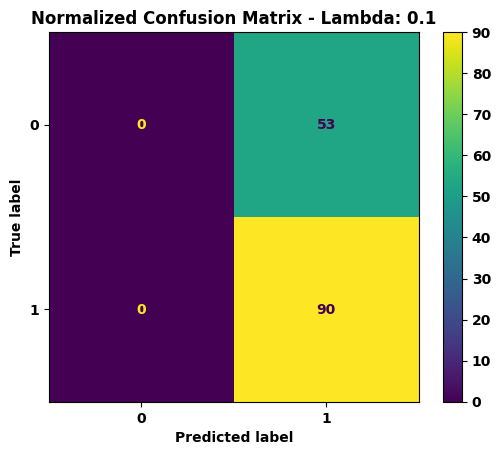

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
from scikitplot.metrics import plot_roc, plot_cumulative_gain

cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train, y_test = y_train.reshape(y_train.shape[0], 1), y_test.reshape(y_test.shape[0], 1)

input_nodes = X_train.shape[1]
hidden_nodes1 = 100
hidden_nodes2 = 30
output_nodes = 1

dims = (input_nodes, hidden_nodes1, hidden_nodes2, output_nodes)

# Assuming you have defined the FFNN class and necessary functions
results_df_custom_FFNN=pd.DataFrame()
# List of lambda values to iterate over
lambda_values = [0.001, 0.005, 0.01, 0.05, 0.1]

for lam in lambda_values:
    neural_network = FFNN(dims, hidden_func=sigmoid, output_func=sigmoid, cost_func=CostLogReg)
    
    neural_network.reset_weights()  # Reset weights for each iteration
    
    scheduler = Adam(eta=1e-4, rho=0.9, rho2=0.9999)
    scores = neural_network.fit(X_train, y_train, scheduler, lam=lam, epochs=10000)
    pred = neural_network.predict(X_test)
    pred_train = neural_network.predict(X_train)
    train_accuracy = np.mean( pred_train == y_train)
    test_accuracy = np.mean(pred == y_test)
   

    # Confusion Matrix
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Normalized Confusion Matrix - Lambda: {}'.format(lambda_val))
    plt.show()

    # Append the results to the DataFrame
    results_df_custom_FFNN = pd.concat([results_df_custom_FFNN, pd.DataFrame({'Lambda': [lambda_val], 'Iteration': [i + 1], 'Train Accuracy':train_accuracy , 'Test Accuracy': [test_accuracy]})], ignore_index=True)





In [31]:
from IPython.display import display
pd.set_option('display.max_rows', None)
display(results_df_custom_FFNN)

,Lambda,Iteration,Train Accuracy,Test Accuracy
0,0.1,5,0.974178,0.937063
1,0.1,5,0.969484,0.930070
2,0.1,5,0.953052,0.895105
3,0.1,5,0.887324,0.818182
4,0.1,5,0.819249,0.818182


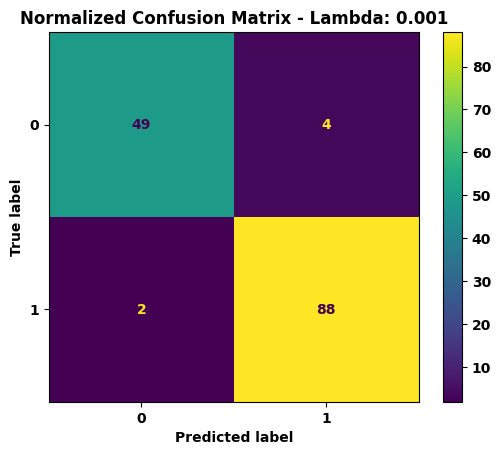

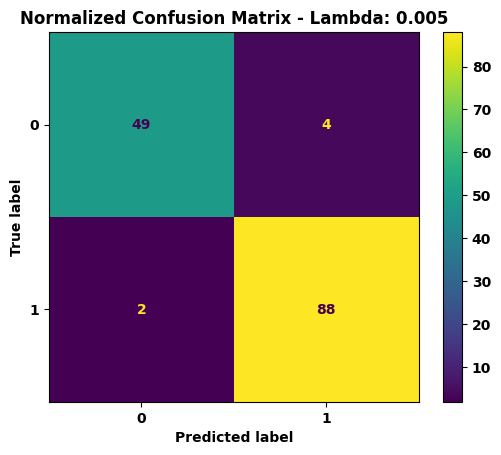

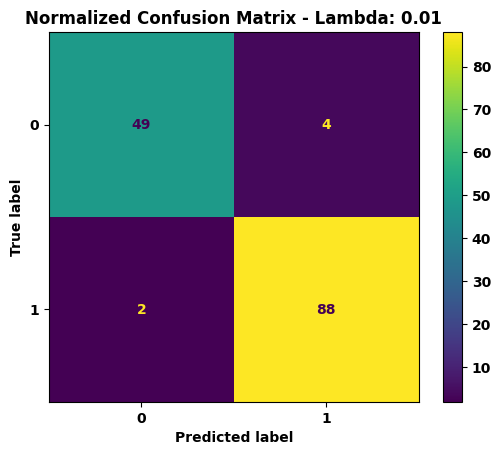

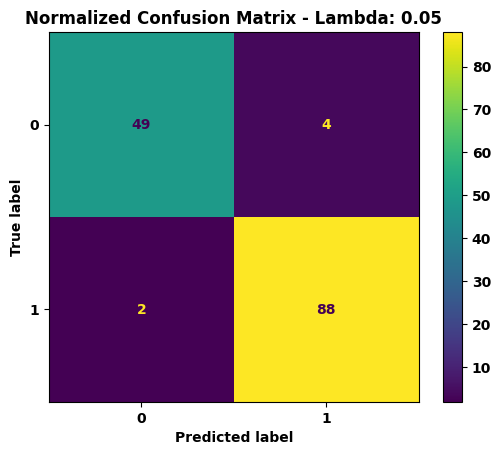

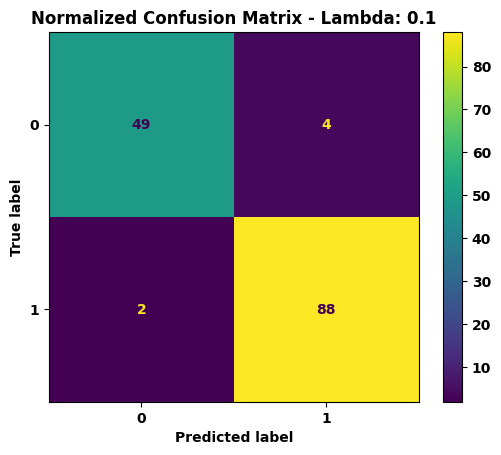

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000, lambda_val=3000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.lambda_val = lambda_val  # Regularization parameter

    def fit(self, X, y):
        m, n = X.shape
        self.theta = np.zeros(n + 1)  # Initialize weights with zeros, including bias term
        X = np.hstack((np.ones((m, 1)), X))  # Add bias term to the input features

        for i in range(self.num_iterations):
            z = np.dot(X, self.theta)
            predictions = sigmoid(z)
            error = predictions - y
            gradient = (np.dot(X.T, error) + self.lambda_val * np.concatenate(([0], self.theta[1:]))) / m
            self.theta -= self.learning_rate * gradient

    def predict(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))  # Add bias term
        probabilities = sigmoid(np.dot(X, self.theta))
        return (probabilities >= 0.5).astype(int)

# Load the data
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define a list of lambda values
lambda_values = [0.001, 0.005, 0.01, 0.05, 0.1]

# Create a DataFrame to store the results
results_df_custom_logreg = pd.DataFrame()

for  i,lambda_val in enumerate(lambda_values):
    # Logistic Regression
    custom_logreg = LogisticRegression(lambda_val=lambda_val)
    custom_logreg.fit(X_train, y_train)
    pred = custom_logreg.predict(X_test)
    pred_train = custom_logreg.predict(X_train)
    # Test set accuracy
    train_accuracy = np.mean( pred_train == y_train)
    test_accuracy = np.mean(pred == y_test)
   

    # Confusion Matrix
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Normalized Confusion Matrix - Lambda: {}'.format(lambda_val))
    plt.show()

    # Append the results to the DataFrame
    results_df_custom_logreg = pd.concat([results_df_custom_logreg, pd.DataFrame({'Lambda': [lambda_val], 'Iteration': [i + 1], 'Train Accuracy':train_accuracy , 'Test Accuracy': [test_accuracy]})], ignore_index=True)




In [22]:
from IPython.display import display
pd.set_option('display.max_rows', None)
display(results_df_custom_logreg)

,Lambda,Iteration,Train Accuracy,Test Accuracy
0,0.001,1,0.981221,0.958042
1,0.005,2,0.981221,0.958042
2,0.010,3,0.981221,0.958042
3,0.050,4,0.981221,0.958042
4,0.100,5,0.981221,0.958042
